# <center>Machine Learning for Banking</center>
_____


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<center><img src="https://datahack-prod.s3.ap-south-1.amazonaws.com/__sized__/contest_cover/cover_1_OIHLvzm-thumbnail-1200x1200.png"/></center>

## Introduction

- Have you ever wondered how lenders use various factors such as credit score, annual income, the loan amount approved, tenure, debt-to-income ratio etc. and select your __interest rates__? 

- The process, defined as ‘__risk-based pricing__’, uses a sophisticated algorithm that leverages different determining factors of a loan applicant. 

Selection of significant factors will help develop a prediction algorithm which can estimate __loan interest rates__ based on --
- clients
- information

On one hand, knowing the factors will help consumers and borrowers to increase their credit worthiness and place themselves in a better position to negotiate for getting a lower interest rate. On the other hand, this will help lending companies to get an immediate fixed interest rate estimation based on clients information. Here, your goal is to use a training dataset to <font color='blue'>__predict the loan rate category (1 / 2 / 3)__</font> that will be assigned to each loan in our test set.

You can use any combination of the features in the dataset to make your loan rate category predictions. Some features will be easier to use than others.



## Evaluation Metric
The evaluation metric for this competition is __Weighted F1 Score__.

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from xgboost import XGBClassifier
from xgboost import plot_importance

# function to plot all features based out of its importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time

from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt


In [0]:
train=pd.read_csv('/content/drive/My Drive/AVCompetition /JanataHack: Machine Learning for Banking/train.csv')

test=pd.read_csv('/content/drive/My Drive/AVCompetition /JanataHack: Machine Learning for Banking/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(164309, 14)
(109541, 13)


In [4]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


## Description of the Dataset

In [5]:
train.isnull().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

In [6]:
test.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,"12,000",10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,"35,000",< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male


In [0]:
test_id=test['Loan_ID']

In [0]:
# combine both train and test data frames
data=train.append(test)

In [9]:
print(data.shape)
data.head()

(273850, 14)


,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1.0
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3.0
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3.0
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3.0
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

In [11]:
train.describe()

,Loan_ID,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate
count,1.643090e+05,1.392070e+05,164309.000000,164309.000000,75930.000000,164309.000000,164309.000000,164309.000000
mean,1.008216e+07,7.333116e+04,17.207189,0.781698,34.229356,11.193818,25.067665,2.158951
std,4.743207e+04,6.037750e+04,7.845083,1.034747,21.761180,4.991813,11.583067,0.738364
min,1.000000e+07,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,1.004108e+07,4.500000e+04,11.370000,0.000000,16.000000,8.000000,17.000000,2.000000
50%,1.008216e+07,6.300000e+04,16.840000,0.000000,31.000000,10.000000,23.000000,2.000000
75%,1.012323e+07,8.869750e+04,22.780000,1.000000,50.000000,14.000000,32.000000,3.000000
max,1.016431e+07,7.500000e+06,39.990000,8.000000,180.000000,76.000000,156.000000,3.000000


## Data Preprocessing

In [0]:
data=data.drop('Loan_ID',axis=1)

In [13]:
data.isnull().sum()

Loan_Amount_Requested           0
Length_Employed             12307
Home_Owner                  42060
Annual_Income               42000
Income_Verified                 0
Purpose_Of_Loan                 0
Debt_To_Income                  0
Inquiries_Last_6Mo              0
Months_Since_Deliquency    147238
Number_Open_Accounts            0
Total_Accounts                  0
Gender                          0
Interest_Rate              109541
dtype: int64

Since most of the columns in the dataset have **missing values** and contain data with textual values in them, they can't be used for **Statistical Analysis** and **Data Visualization** without performing **Data Preprocessing** on them. <br>

In [14]:
data.head(3)

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1.0
1,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3.0
2,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3.0


In [15]:
data.dtypes

Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate              float64
dtype: object

### Loan_Amount_Requested

In [16]:
data['Loan_Amount_Requested'].dtype

dtype('O')

In [0]:
data['Loan_Amount_Requested']=data['Loan_Amount_Requested'].str.replace(',','').astype(float)

In [18]:
data['Loan_Amount_Requested'].dtype

dtype('float64')

### Length_Employed 

In [19]:
# Treating Lenth_employed feature

# Checking Employment.Length column

data['Length_Employed'].value_counts(dropna=False)

10+ years    88328
2 years      24420
3 years      21478
< 1 year     21133
5 years      18042
1 year       17336
4 years      16393
7 years      15444
6 years      15351
8 years      13115
NaN          12307
9 years      10503
Name: Length_Employed, dtype: int64

In [0]:
# Removing 'year' and 'years' from Employment.Length.

data['Length_Employed'] = data['Length_Employed'].astype('str')
data['Length_Employed'] = data['Length_Employed'].str.replace(' years', '').str.replace(' year', '')

In [21]:
# train['Length_Employed']

round(data.groupby('Length_Employed')['Interest_Rate'].mean(), 2)

Length_Employed
1      2.12
10+    2.18
2      2.14
3      2.13
4      2.14
5      2.16
6      2.17
7      2.19
8      2.16
9      2.19
< 1    2.11
nan    2.19
Name: Interest_Rate, dtype: float64

- As you can see **NA's** has an **Interest.Rate** similar to **9**.

In [0]:
data['Length_Employed'] = data['Length_Employed'].str.replace('< 1', '0').str.replace('+', '').str.replace('nan', '9')

### Annual_Income

In [0]:
# fill annual_income with the median value
data['Annual_Income']=data['Annual_Income'].fillna(data['Annual_Income'].median())

### Home_Owner

In [24]:
data['Home_Owner'].value_counts()

Mortgage    117270
Rent         93542
Own          20879
Other           79
None            20
Name: Home_Owner, dtype: int64

In [0]:
data['Home_Owner']=data['Home_Owner'].fillna('Mortgage')

In [26]:
# data=data.drop('Months_Since_Deliquency',axis=1)

print(data['Months_Since_Deliquency'].mean())

print(data['Months_Since_Deliquency'].median())


34.10339462294253
31.0


In [0]:
data['Months_Since_Deliquency']=data['Months_Since_Deliquency'].fillna(data['Months_Since_Deliquency'].median())

In [0]:
# # data['Months_Since_Deliquency'].plot(kind='hist')
# n=np.log1p(data['Months_Since_Deliquency'])
# n.plot(kind='hist')

### Treating categorical variables.

In [29]:
data.dtypes

Loan_Amount_Requested      float64
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate              float64
dtype: object

In [30]:
data['Purpose_Of_Loan'].value_counts()

debt_consolidation    161403
credit_card            61394
home_improvement       15455
other                  13846
major_purchase          5712
small_business          4064
car                     3149
medical                 2633
moving                  1675
vacation                1453
wedding                 1345
house                   1316
renewable_energy         206
educational              199
Name: Purpose_Of_Loan, dtype: int64

In [0]:
# Treat the skewed feature i.e ['Total_Accounts','Number_Open_Accounts'] 


# data['Debt_To_Income'].plot(kind='hist')
# n=np.log1p(data['Number_Open_Accounts'])
# n.plot(kind='hist')


# p=np.log1p(data['Total_Accounts'])
# p.plot(kind='hist')

In [0]:
# Treat skewness
data['Number_Open_Accounts']=np.log1p(data['Number_Open_Accounts'])

data['Total_Accounts']=np.log1p(data['Total_Accounts'])

In [33]:
data.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000.0,0,Rent,68000.0,not verified,car,18.37,0,31.0,2.302585,2.708050,Female,1.0
1,30000.0,4,Mortgage,63000.0,VERIFIED - income,debt_consolidation,14.93,0,17.0,2.564949,3.218876,Female,3.0
2,24725.0,7,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,31.0,2.564949,2.833213,Male,3.0
3,16000.0,0,Mortgage,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,31.0,2.833213,3.135494,Male,3.0
4,17000.0,8,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,31.0,2.995732,3.433987,Female,1.0


In [0]:
data['Length_Employed']=data['Length_Employed'].astype(int)

In [35]:
data.dtypes

Loan_Amount_Requested      float64
Length_Employed              int64
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts       float64
Total_Accounts             float64
Gender                      object
Interest_Rate              float64
dtype: object

In [0]:
# Converting to categorical variable.

col=['Gender','Home_Owner','Income_Verified','Length_Employed','Purpose_Of_Loan','Inquiries_Last_6Mo']

for c in col:
    data = pd.get_dummies(data, columns=[c])

In [37]:
data.head()

,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate,Gender_Female,Gender_Male,Home_Owner_Mortgage,Home_Owner_None,Home_Owner_Other,Home_Owner_Own,Home_Owner_Rent,Income_Verified_VERIFIED - income,Income_Verified_VERIFIED - income source,Income_Verified_not verified,Length_Employed_0,Length_Employed_1,Length_Employed_2,Length_Employed_3,Length_Employed_4,Length_Employed_5,Length_Employed_6,Length_Employed_7,Length_Employed_8,Length_Employed_9,Length_Employed_10,Purpose_Of_Loan_car,Purpose_Of_Loan_credit_card,Purpose_Of_Loan_debt_consolidation,Purpose_Of_Loan_educational,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Inquiries_Last_6Mo_0,Inquiries_Last_6Mo_1,Inquiries_Last_6Mo_2,Inquiries_Last_6Mo_3,Inquiries_Last_6Mo_4,Inquiries_Last_6Mo_5,Inquiries_Last_6Mo_6,Inquiries_Last_6Mo_7,Inquiries_Last_6Mo_8
0,7000.0,68000.0,18.37,31.0,2.302585,2.708050,1.0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,30000.0,63000.0,14.93,17.0,2.564949,3.218876,3.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,24725.0,75566.4,15.88,31.0,2.564949,2.833213,3.0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,16000.0,56160.0,14.34,31.0,2.833213,3.135494,3.0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,17000.0,96000.0,22.17,31.0,2.995732,3.433987,1.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [0]:
# cols=['Loan_Amount_Requested','Annual_Income','Debt_To_Income','Months_Since_Deliquency','Number_Open_Accounts','Total_Accounts']

In [0]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [0]:
# for i in cols:
#   data[i]=scaler.fit_transform(data[i].values.reshape(-1,1))

In [0]:
train=data[data['Interest_Rate'].notnull()]
test=data[data['Interest_Rate'].isnull()]

In [42]:
train.head()

,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate,Gender_Female,Gender_Male,Home_Owner_Mortgage,Home_Owner_None,Home_Owner_Other,Home_Owner_Own,Home_Owner_Rent,Income_Verified_VERIFIED - income,Income_Verified_VERIFIED - income source,Income_Verified_not verified,Length_Employed_0,Length_Employed_1,Length_Employed_2,Length_Employed_3,Length_Employed_4,Length_Employed_5,Length_Employed_6,Length_Employed_7,Length_Employed_8,Length_Employed_9,Length_Employed_10,Purpose_Of_Loan_car,Purpose_Of_Loan_credit_card,Purpose_Of_Loan_debt_consolidation,Purpose_Of_Loan_educational,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Inquiries_Last_6Mo_0,Inquiries_Last_6Mo_1,Inquiries_Last_6Mo_2,Inquiries_Last_6Mo_3,Inquiries_Last_6Mo_4,Inquiries_Last_6Mo_5,Inquiries_Last_6Mo_6,Inquiries_Last_6Mo_7,Inquiries_Last_6Mo_8
0,7000.0,68000.0,18.37,31.0,2.302585,2.708050,1.0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,30000.0,63000.0,14.93,17.0,2.564949,3.218876,3.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,24725.0,75566.4,15.88,31.0,2.564949,2.833213,3.0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,16000.0,56160.0,14.34,31.0,2.833213,3.135494,3.0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,17000.0,96000.0,22.17,31.0,2.995732,3.433987,1.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [0]:
# print(train['Annual_Income'].max())
# print(train['Annual_Income'].mean())
# print(train['Annual_Income'].median())

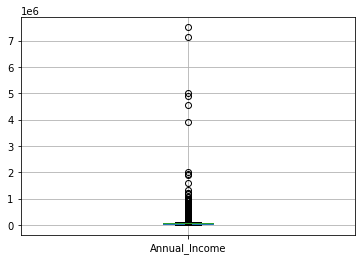

In [44]:
# treating the outliers of the training data.

train.boxplot(column=['Annual_Income'])
# from the give plot we can see distribution of data['Annual_Income] and top two points are the extreme outliers so lets drop them


In [0]:
# drop all the rown have annual_income more than 4000000.
ind=train[train['Annual_Income']>4000000].index
train=train.drop(ind,axis=0)

In [0]:
# train.boxplot(column=['Months_Since_Deliquency'])

In [0]:
# print(train['Total_Accounts'].mean())
# print(train['Total_Accounts'].median())

# print(train['Total_Accounts'].max())

In [0]:
# train.head()

In [0]:
test.head()
test=test.drop('Interest_Rate',axis=1)

In [50]:
print(test.shape)
print(train.shape)

(109541, 50)
(164304, 51)


In [0]:
X=train.drop('Interest_Rate',axis=1)
Y=train['Interest_Rate']

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

In [0]:
from sklearn.metrics import accuracy_score,f1_score

In [0]:
# model=XGBClassifier()

# # Various hyper-parameters to tune
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['multi:softprob'],
#               'silent': [1],
#               'learning_rate': [0.035],
#               'n_estimators': [4500],
#               'max_depth': [7,9],
#               'min_child_weight': [5],
#               'gamma':[0.01,0.03],
#               'subsample': [0.865],
#               'scale_pos_weight':[1],
#               'colsample_bytree':[0.875],
#               'reg_alpha':[0.00125],
#               'reg_lambda':[0.825]}

In [0]:
# rscvj1 = RandomizedSearchCV(model,
#                             parameters,
#                             n_jobs=5,
#                             cv=2)

In [0]:
# ts=time.time()

# rscvj1.fit(
#     X_train, 
#     y_train,
#     eval_metric="merror", 
#     eval_set=[(X_train, y_train), (X_test, y_test)], 
#     verbose=True, 
#     early_stopping_rounds = 100
# )

# # time.time-ts

Best Parameter are found:

{'colsample_bytree': 0.875,
 'gamma': 0.03,
 'learning_rate': 0.035,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 4500,
 'nthread': 4,
 'objective': 'multi:softprob',
 'reg_alpha': 0.00125,
 'reg_lambda': 0.825,
 'scale_pos_weight': 1,
 'silent': 1,
 'subsample': 0.865}

In [0]:
rscvj1.best_params_

{'colsample_bytree': 0.875,
 'gamma': 0.03,
 'learning_rate': 0.035,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 4500,
 'nthread': 4,
 'objective': 'multi:softprob',
 'reg_alpha': 0.00125,
 'reg_lambda': 0.825,
 'scale_pos_weight': 1,
 'silent': 1,
 'subsample': 0.865}

In [0]:
model = XGBClassifier(
    colsample_bytree= 0.875,
    gamma=0.03,
    learning_rate= 0.035,
    max_depth=7,
    min_child_weight= 5,
    n_estimators= 4500,
    nthread= 4,
    objective=['multi:softprob'],
    reg_alpha= 0.00125,
    reg_lambda=0.825,
    scale_pos_weight=1,
    silent=1,
    subsample=0.865
    )


In [0]:
# # fit the model
start_time=time.time()

# # model = model.fit(X_train,y_train)

model.fit(
    X_train, 
    y_train, 
    eval_metric="merror", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 100)

end_time=time.time() - start_time
print(end_time)

[0]	validation_0-merror:0.485228	validation_1-merror:0.498093
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[1]	validation_0-merror:0.475742	validation_1-merror:0.488903
[2]	validation_0-merror:0.47429	validation_1-merror:0.488903
[3]	validation_0-merror:0.47309	validation_1-merror:0.488051
[4]	validation_0-merror:0.471716	validation_1-merror:0.485089
[5]	validation_0-merror:0.470612	validation_1-merror:0.485353
[6]	validation_0-merror:0.468977	validation_1-merror:0.485495
[7]	validation_0-merror:0.469977	validation_1-merror:0.483993
[8]	validation_0-merror:0.469273	validation_1-merror:0.484602
[9]	validation_0-merror:0.469603	validation_1-merror:0.484805
[10]	validation_0-merror:0.468395	validation_1-merror:0.483648
[11]	validation_0-merror:0.467595	validation_1-merror:0.482695
[12]	validation_0-merror:0.467395	validation_1-merror:0.482715
[13]	validation_0-merror:0.46

In [0]:

# make predictions for test set
y_pred = rscvj1.predict(X_test)
predictions = [round(value) for value in y_pred]

In [0]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 54.22%


In [0]:
from sklearn import metrics


0.0001270771026611328

In [0]:
print(metrics.confusion_matrix(y_test, predictions))

[[ 2779  6145  1323]
 [ 1866 13462  5804]
 [  459  6969 10485]]


In [0]:
print(metrics.classification_report(y_test, predictions, digits=3))

              precision    recall  f1-score   support

         1.0      0.544     0.271     0.362     10247
         2.0      0.507     0.637     0.564     21132
         3.0      0.595     0.585     0.590     17913

    accuracy                          0.542     49292
   macro avg      0.549     0.498     0.506     49292
weighted avg      0.547     0.542     0.532     49292



In [0]:
pred=rscvj1.predict(test)

In [0]:
pred=pred.astype(int)
pred

array([2, 1, 3, ..., 2, 3, 2])

In [0]:
final=pd.DataFrame(columns=['Loan_ID','Interest_Rate'])

In [0]:
final['Loan_ID']=test_id
final['Interest_Rate']=pred

In [0]:
final.to_csv('submission5.csv',encoding='utf-8', index=False)